Epoch:0,训练平均损失:0.5698, 训练准确度:0.865
Epoch:1,训练平均损失:0.5739, 训练准确度:0.802
Epoch:2,训练平均损失:0.5927, 训练准确度:0.771
Epoch:3,训练平均损失:0.4606, 训练准确度:0.833
Epoch:4,训练平均损失:0.5077, 训练准确度:0.844
Epoch:5,训练平均损失:0.4499, 训练准确度:0.865
Epoch:6,训练平均损失:0.4158, 训练准确度:0.854
Epoch:7,训练平均损失:0.5296, 训练准确度:0.823
Epoch:8,训练平均损失:0.5048, 训练准确度:0.792
Epoch:9,训练平均损失:0.4452, 训练准确度:0.844
Epoch:10,训练平均损失:0.4679, 训练准确度:0.885
Epoch:11,训练平均损失:0.4682, 训练准确度:0.865
Epoch:12,训练平均损失:0.5391, 训练准确度:0.844
Epoch:13,训练平均损失:0.3550, 训练准确度:0.896
Epoch:14,训练平均损失:0.4075, 训练准确度:0.885
Epoch:15,训练平均损失:0.4395, 训练准确度:0.833
Epoch:16,训练平均损失:0.4842, 训练准确度:0.844
Epoch:17,训练平均损失:0.6163, 训练准确度:0.812
Epoch:18,训练平均损失:0.3203, 训练准确度:0.875
Epoch:19,训练平均损失:0.3355, 训练准确度:0.875
Epoch:20,训练平均损失:0.4712, 训练准确度:0.833
Epoch:21,训练平均损失:0.7049, 训练准确度:0.802
Epoch:22,训练平均损失:0.3532, 训练准确度:0.875
Epoch:23,训练平均损失:0.5107, 训练准确度:0.844
Epoch:24,训练平均损失:0.5886, 训练准确度:0.792
Epoch:25,训练平均损失:0.3304, 训练准确度:0.917
Epoch:26,训练平均损失:0.4146, 训练准确度:0.854
Epoch:27,训练平均损失:0.3774, 训练准确度:0.896
Ep

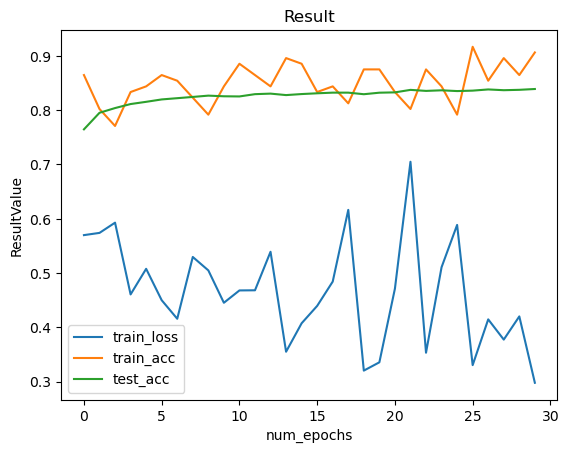

/tmp/ipykernel_82580/1524366627.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1, n, figsize=(8, 8))


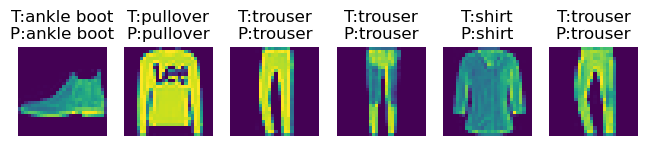

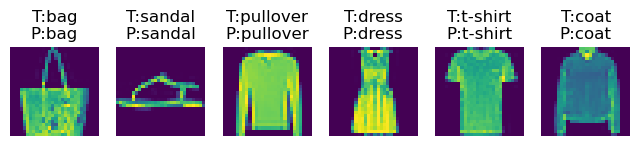

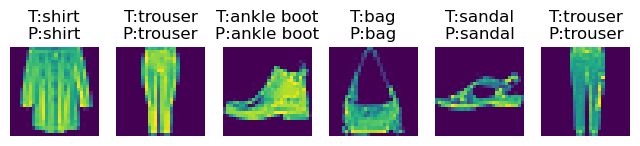

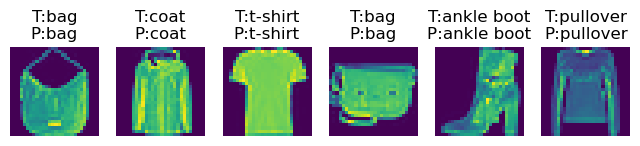

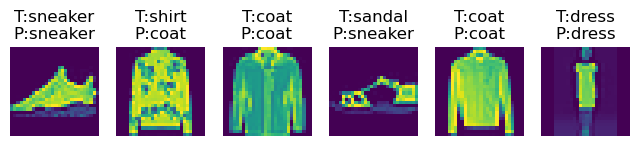

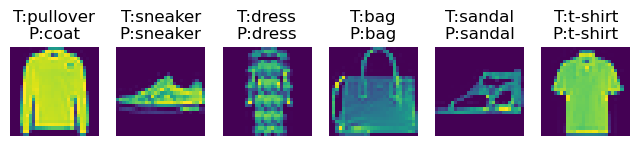

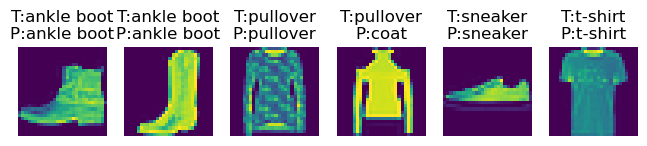

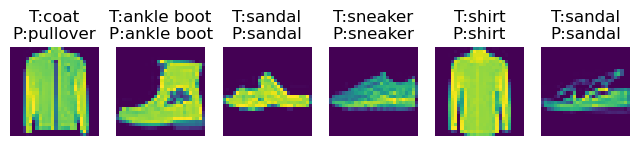

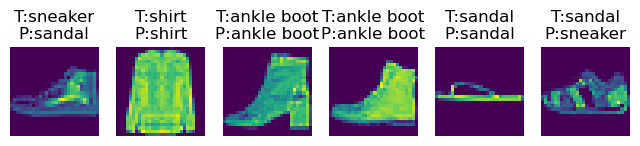

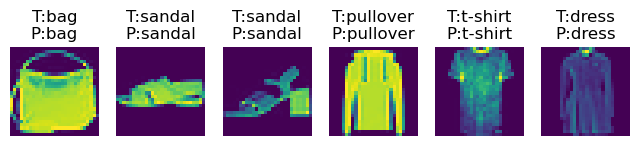

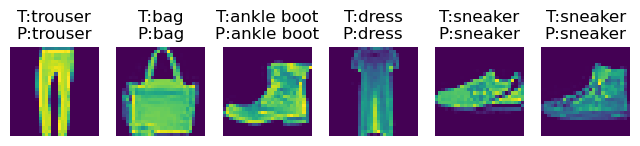

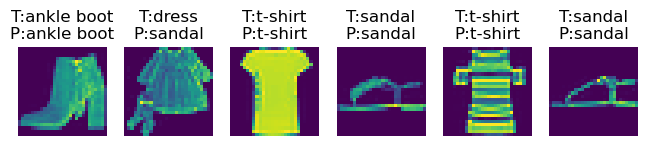

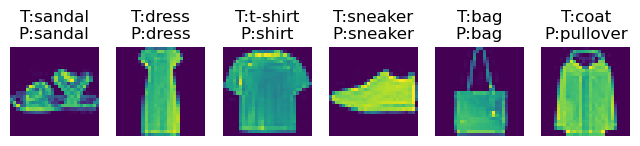

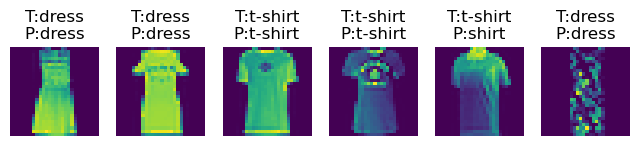

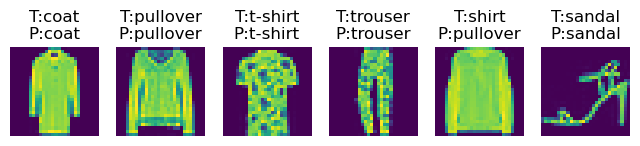

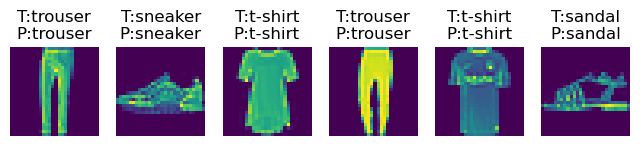

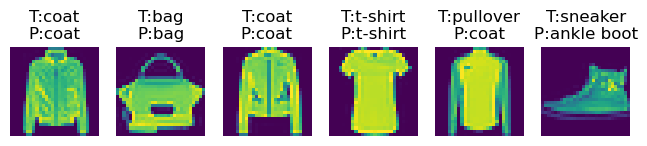

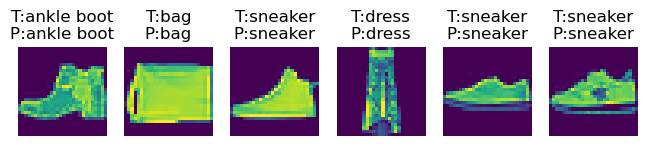

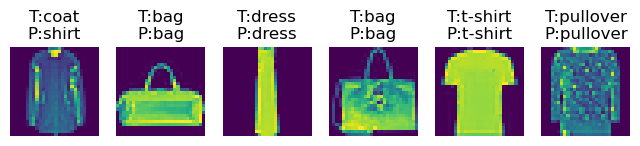

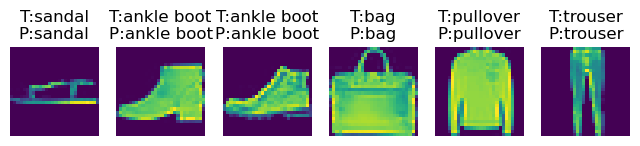

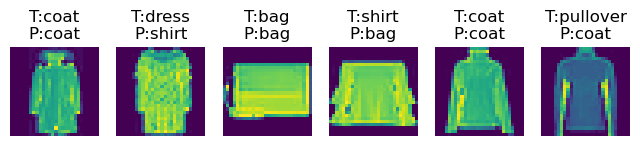

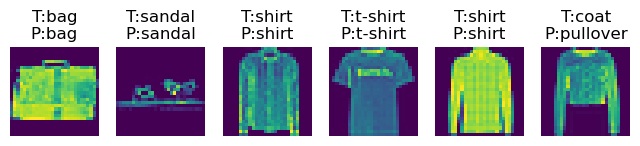

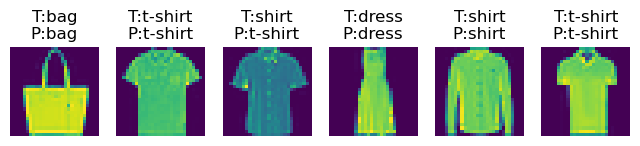

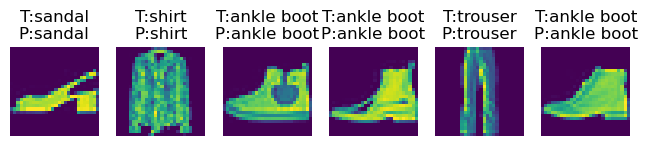

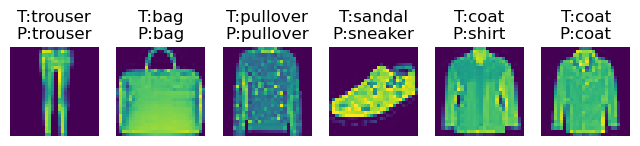

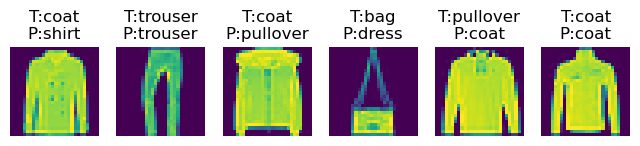

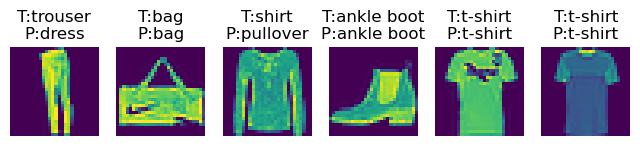

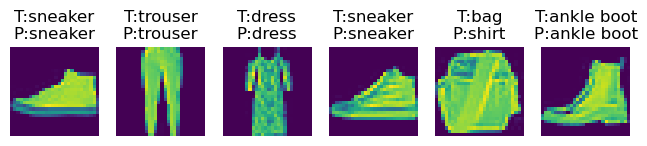

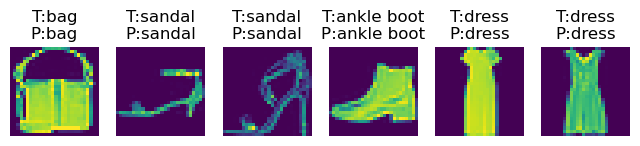

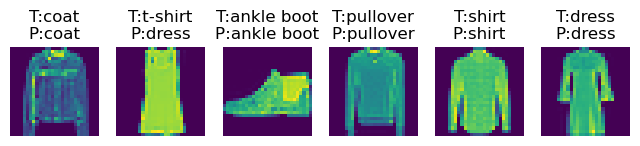

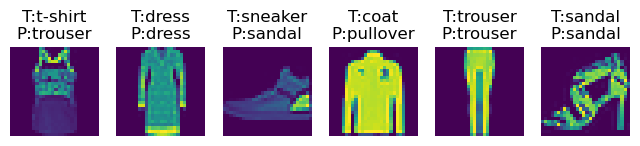

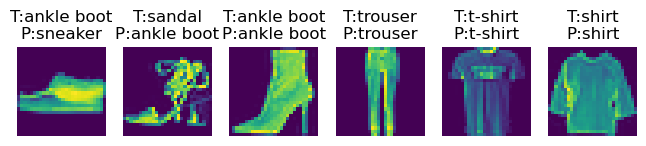

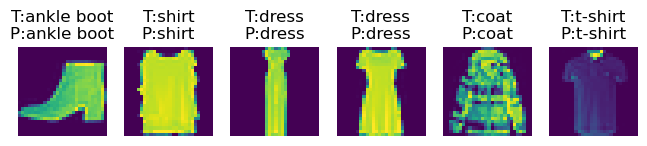

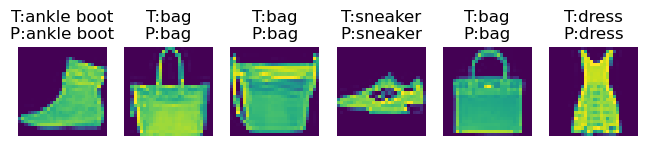

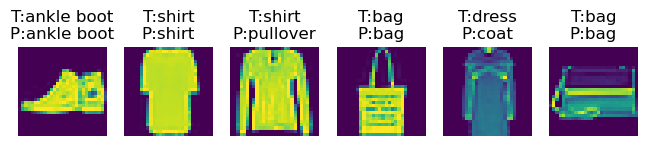

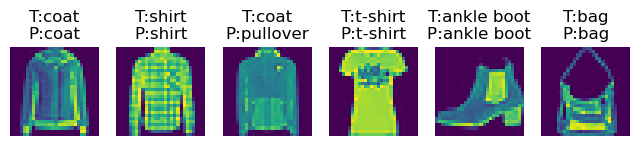

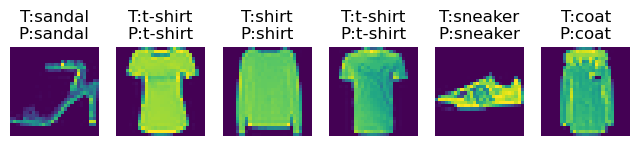

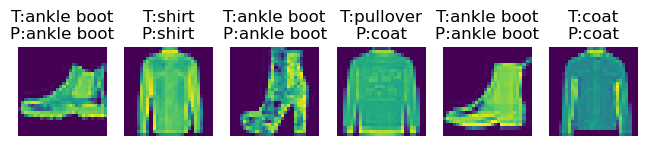

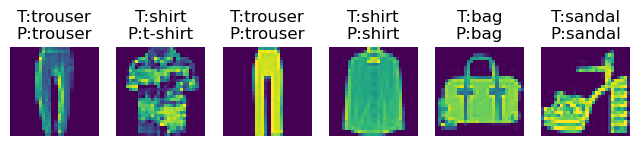

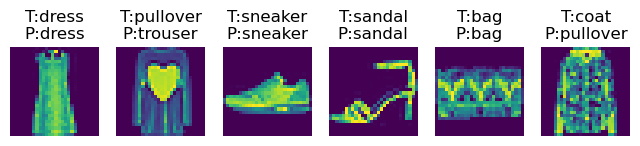

In [1]:
import sys
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt


class Accumulator:  # 累加多个变量的实用程序类
    def __init__(self, n):
        self.data = [0.0]*n

    def add(self, *args):  # 在data的对应位置加上对应的数
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    

class ResVisualization:
    def __init__(self, legend_name:tuple, num_epochs) -> None:
        self.res_dict = {name : [] for name in legend_name}
        self.num_epochs = num_epochs

    def plot_res(self):
        for legend_name, data in self.res_dict.items():
            plt.plot(list(range(self.num_epochs)), data, label=legend_name)
        plt.title("Result")
        plt.xlabel("num_epochs")
        plt.ylabel("ResultValue")
        plt.legend()
        plt.show()

# 小批量的Softmax回归
# 使用Fashion-MINST数据集 集中的图片大小为28*28
def get_MINST_labels(labels):  # 获取训练集中的数据对应的标签 labels参数传入 MINST_train.train_labels
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def load_data(batch_size, resize=False):
    trans = [transforms.ToTensor()]  # 格式转换的列表 列表里的所有内容在格式转换时都会被应用
    if resize:  # 如果指定了需要重置大小
        # 在trans列表开头位置添加transforms.Resize类
        trans.insert(0, transforms.Resize(resize))
    # 将trans列表中的内容整合在一起 形成一个整合类 之后可调用 transformedd_img=trans(img) 初始化img
    trans = transforms.Compose(trans)
    MINST_train = torchvision.datasets.FashionMNIST(
        root='./data', transform=trans, train=True, download=True)
    MINST_test = torchvision.datasets.FashionMNIST(
        root='./data', transform=trans, train=False, download=True)
    return (data.DataLoader(MINST_train, batch_size, shuffle=True, num_workers=16),
            data.DataLoader(MINST_test, batch_size, shuffle=False, num_workers=16))


def Softmax(X):  # Softmax基于随机输入,将每个元素变成非负数,依据概率原理,每行的总和为1
    """
    Softmax(X)[i][j] = exp(X[i][j]) / Sigma(X[i][k]) 即每个位置的Softmax就是这个位置的值的Exp除以这一行的Exp求和
    """
    X_exp = torch.exp(X)  # Softmax的分子
    partition = X_exp.sum(1, keepdim=True)  # Softmax的分母
    return X_exp / partition  # 使用了广播机制


def net(X, W):  # 定义模型
    return Softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)


def cross_entropy(y_hat, y):
    """
    交叉熵采用真实标签的预测概率的负对数似然
    y[]是一个张量,表示每个数据的正确预测的标签
    y_hat[range(len(y_hat)), y] 表达式表示对于每个y[i],找到对应的y_hat预测的概率
    比如：
    y = torch.tensor([0, 2])
    y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
    y_hat[[0, 1], y] 输出tensor([0.1000, 0.5000]) 
    表示 因为y中正确的标签是 0类 和 2类,这是一种切片方法
    取出 y_hat中每行的y_hat[i][y[correct_label]]的概率
    在多分类(非二元分类)问题中,交叉熵可被简化为-log(p_y),p_y是模型对正确类别y的预测概率
    """
    return -torch.log(y_hat[range(len(y_hat)), y])


def accuracy(y_hat, y):  # 计算预测正确的数量
    """
    如果y_hat存储的是矩阵,假定第二个维度存储每个类的预测分数
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 取出y_hat中每一行中的最大的那个概率的索引
    # 比较y_hat和y中的每个位置相不相等, 注意这之前要先把它们的类型转换为一样的 .type(dtype)函数表示将这个tensor的类型转为dtype
    compare = y_hat.type(y.dtype) == y
    return float(compare.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):  # 对于任何data_iter可访问的数据集 都可以评估模型的精度
    if isinstance(net, nn.Module):
        net.eval()  # 模型设置为评估模式
    metric = Accumulator(2)  # 2个位置为 正确预测数和预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X, W), y), y.numel()) # tensor.numel返回张量中的元素总数
    return metric[0] / metric[1]


def train_epoch(net, train_set, loss_function, updater):  # 模型在训练周期中的一次训练
    """
    updater是更新模型参数的函数,接收批量大小作为参数
    updater可以是sgd函数 也可以是框架内的内置函数
    """
    if isinstance(net, nn.Module):
        net.train()
    metric = Accumulator(3)  # 三个位置为 训练损失总和 训练准确数 样本数
    for X, y in train_set:
        y_hat = net(X, W)  # 给出一次预测
        loss = loss_function(y_hat, y)  # 计算损失
        if isinstance(updater, torch.optim.Optimizer):  # updater为Pytorch框架的内置优化器
            updater.zero_grad()  # 将grad置为0 因为pytorch计算梯度时会累加
            loss.mean().backward()  # 计算梯度
            updater.step()  # 由计算出的梯度更新参数
        else:  # 使用的是定制的优化器和损失函数
            loss.sum().backward()
            updater(X.shape[0]) # 参数:batch_size
    metric.add(float(loss.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]  # 返回训练损失和训练精度


def train(net, train_set, test_set, loss_function, num_epochs, updater, Res : ResVisualization):  # 训练模型
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_set, loss_function, updater)
        print(f"Epoch:{epoch},训练平均损失:{train_metrics[0] :.4f}, 训练准确度:{train_metrics[1]:.3f}")
        test_accurancy = evaluate_accuracy(net, test_set)
        Res.res_dict['train_loss'].append(train_metrics[0])
        Res.res_dict['train_acc'].append(train_metrics[1])
        Res.res_dict['test_acc'].append(test_accurancy)
    train_loss, train_accuracy = train_metrics
    assert train_loss < 0.7, train_loss
    assert train_accuracy <= 1 and train_accuracy > 0.7, train_accuracy
    assert test_accurancy <= 1 and test_accurancy > 0.7, test_accurancy


def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= learning_rate * param.grad / batch_size
            param.grad.zero_()


def updater(batch_size):
    return sgd(params=[W, b], lr=learning_rate, batch_size=batch_size)


def prediction(net, test_set, n=6):
    for X, y in test_set:
        _, axes = plt.subplots(1, n, figsize=(8, 8))
        true_labels = get_MINST_labels(y)
        pred_labels = get_MINST_labels(net(X, W).argmax(axis=1))
        titles = ['T:'+ true + '\n' + 'P:'+ pred for true,
                  pred in zip(true_labels, pred_labels)]
        for i in range(n):
            axes[i].imshow(X[i].reshape((28, 28)))
            axes[i].set_title(titles[i])
            axes[i].axis('off')

# 预测图片类别
batch_size = 256
num_inputs = 784  # 一个图片有784个像素 即输入维度有784
num_outputs = 10  # 共有10个类别 即输出维度为10
learning_rate = 0.05
num_epochs = 30
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs),
                 requires_grad=True)  # 初始化权重矩阵
b = torch.zeros(num_outputs, requires_grad=True)  # 初始化偏置矩阵
train_set, test_set = load_data(batch_size)
Res = ResVisualization(("train_loss", "train_acc", "test_acc"), num_epochs) # 结果绘图
train(net, train_set, test_set, cross_entropy, num_epochs, updater, Res)
Res.plot_res()
prediction(net, test_set)